In [1]:
from pyarrow import fs, schema, string
from pyarrow.dataset import FilenamePartitioning
import pyarrow.dataset as ds
import boto3
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from mats_utils.rawdata.read_data import read_MATS_data
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy import optimize
import scipy.interpolate as interp
from scipy.spatial.transform import Rotation as R
import io
from tangentlib import *
from PIL import Image, ImageFilter
from mats_l1_processing.read_parquet_functions import *
from mats_l1_processing.L1_calibration_functions import *
from mats_utils.geolocation.coordinates import *
from skyfield import api as sfapi
import skyfield.sgp4lib as sgp4lib
from skyfield.framelib import itrs
from skyfield.positionlib import Geocentric
#%matplotlib widget


In [2]:
starttime = DT.datetime(2023,2, 13, 0, 30, 0)
endtime = DT.datetime(2023, 2, 13, 12, 45, 0)
df = read_MATS_data(starttime, endtime,filter=None,level='1b',version='0.4')


In [3]:
print('Number of images = ',df.shape[0])
clim=999
plt.close('all')
ccdnames=('IR1','IR4','IR3','IR2','UV1','UV2','NADIR')
flip=(True,False,True,False,True,True,False)
ir1=df[df.CCDSEL==1]
ir2=df[df.CCDSEL==4]
ir3=df[(df.CCDSEL==3)]
ir4=df[(df.CCDSEL==2)]
uv1=df[(df.CCDSEL==5)]
uv2=df[(df.CCDSEL==6)]
for ch in [ir1,ir2,ir3,ir4,uv1,uv2]:
    print (ccdnames[ch.CCDSEL.iloc[0]-1],  ch.shape[0])
ir1.shape

Number of images =  18
IR1 3
IR2 3
IR3 3
IR4 3
UV1 3
UV2 3


(3, 78)

In [4]:
def make_ths(ccditem):
    xpixels = np.linspace(0, ccditem['NCOL'], 5)
    ypixels = np.linspace(0, ccditem['NROW'], 10)
    ths = np.zeros([xpixels.shape[0], ypixels.shape[0]])
    print (ths.shape)
    for i,col in enumerate(xpixels): 
        ths[i,:]=col_heights(ccditem,col,40,spline=True)(ypixels)
    return xpixels,ypixels,ths.T

In [5]:
ch.columns

Index(['EXPDate', 'OriginFile', 'ProcessingTime', 'RamsesTime',
       'QualityIndicator', 'LossFlag', 'VCFrameCounter', 'SPSequenceCount',
       'TMHeaderNanoseconds', 'SID', 'RID', 'CCDSEL', 'EXPNanoseconds',
       'WDWMode', 'WDWInputDataWindow', 'WDWOV', 'JPEGQ', 'FRAME', 'NROW',
       'NRBIN', 'NRSKIP', 'NCOL', 'NCBINFPGAColumns', 'NCBINCCDColumns',
       'NCSKIP', 'NFLUSH', 'TEXPMS', 'GAINMode', 'GAINTiming',
       'GAINTruncation', 'TEMP', 'FBINOV', 'LBLNK', 'TBLNK', 'ZERO', 'TIMING1',
       'TIMING2', 'VERSION', 'TIMING3', 'NBC', 'BadColumns', 'ImageName',
       'afsAttitudeState', 'afsGnssStateJ2000', 'afsTPLongLatGeod',
       'afsTangentH_wgs84', 'afsTangentPointECI', 'satlat', 'satlon',
       'satheight', 'TPlat', 'TPlon', 'TPheight', 'nadir_sza', 'TPsza',
       'TPssa', 'TPlocaltime', 'HTR1A', 'HTR1B', 'HTR1OD', 'HTR2A', 'HTR2B',
       'HTR2OD', 'HTR7A', 'HTR7B', 'HTR7OD', 'HTR8A', 'HTR8B', 'HTR8OD',
       'ImageCalibrated', 'CalibrationErrors', 'qprime', 'chann

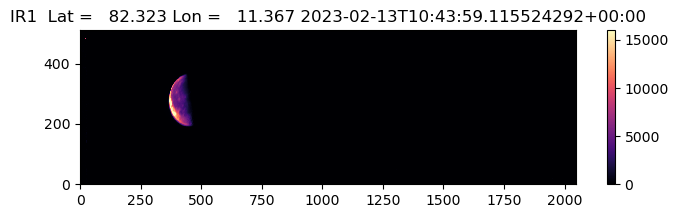

In [6]:

i=0

ch=ir1;clims=[0,16000]
#ch=ir2;clims=[0,1000]
#ch=ir4;clims=[0,60]
#ch=ir3;clims=[0,10]
#ch=uv1;clims=[0,8000]
flip=(True,False,True,False,True,True,False)
fig,axis=plt.subplots(1,1,figsize=[8,2])
try: 
    image=np.stack(ch.ImageCalibrated.iloc[i])
except:
    image = np.float64(Image.open(io.BytesIO(ch.iloc[i].ImageData)))
    if (flip[ch.CCDSEL.iloc[i] - 1]) : image=np.fliplr(image)
sp=plt.imshow(image, cmap="magma", origin="lower", interpolation="none")
axis.axis("auto")
TPlat,TPlon,satalt=satpos(ch.iloc[i])
plt.title("{:4s} Lat = {:8.3f} Lon = {:8.3f} {:s}".format(ccdnames[ch.iloc[i].CCDSEL - 1 ], TPlat, TPlon ,ch.EXPDate.iloc[i].isoformat()))
#CS = axis.contour(*make_ths(ch.iloc[i]), [
#                  50000,  60000, 70000, 80000, 90000, 100000, 110000,200000,250000,300000], colors='w')
#axis.clabel(CS, inline=True)
plt.clim(clims)
plt.colorbar()
plt.show()

In [10]:
def resample_moon (ch):
    def circle(xc,yc,r,f=0):
        cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
        return cir
    ts = sfapi.load.timescale()
    planets = sfapi.load('de421.bsp')
    earth = planets['Earth']
    sun = planets['Sun']
    moon= planets['moon']
    ecipos = ch['afsGnssStateJ2000'][0:3]
    d = ch['EXPDate']
    t = ts.from_datetime(d)
    mats = Geocentric(position_au=Distance(m=ch['afsGnssStateJ2000'][0:3]).au, t=t)
    st_vec=(earth+wgs84.subpoint(mats)).at(t).observe(moon).position.km
    centrex = 2047./2
    centrey = 510./2
    xdispersion = 6.06 / 2047  # deg/pix
    ydispersion = 1.52/510  # deg/pix
    q = ch['afsAttitudeState']
    quat = R.from_quat(np.roll(q, -1))
    qprime = ch['qprime']
    qprime = quat * R.from_quat(qprime)  #Rot.from_quat(qprimes[ch])
    x, y = xyz2radec(np.expand_dims(qprime.inv().apply(st_vec), axis=1), deg=True)
    x0 = int(x[0]/xdispersion + centrex)
    y0 = int(-y[0]/ydispersion + centrey)
    print(ch['channel'],x0,y0)
    radius=np.rad2deg(1738.1/norm(st_vec-ecipos/1000))/ydispersion
    print('Radius = ', radius)
    box=120
    try: 
        image=np.stack(ch.ImageCalibrated)
    except:
        image = np.float64(Image.open(io.BytesIO(ch.ImageData)))
        if (flip[ch.CCDSEL.iloc[i] - 1]) : image=np.fliplr(image)
    testimage=image[y0-box:y0+box+1,x0-box:x0+box+1]
    # plt.figure()
    # sp=plt.imshow(testimage, cmap="magma", origin="lower", interpolation="none")
    # axis.axis("auto")
    # cir=np.array(circle (box,box,radius,f=0.0012))
    # plt.plot(cir[:,0],cir[:,1],'r')
    testimage[testimage<1500]=0 #get rid of noisy pixels
    testimage=testimage.astype('int32')
    test=Image.fromarray(testimage,mode='I')
    test = test.convert("L")
    edges = test.filter(ImageFilter.FIND_EDGES)
    ared=np.array(edges)
    # plt.figure()
    # plt.imshow(edges,origin='lower')
    # plt.colorbar()
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    y,x=(ared[:,0:box-20]>10).nonzero()
    x=x+1
    y=y+1 #seems to find the outside of the edge så move one pixel
    center_estimate = box, box
    Ri=calc_R(*center_estimate)
    filter=np.abs(Ri-radius)< 0.2*Ri.mean()
    x=x[filter]
    y=y[filter]
    center_2, ier = optimize.leastsq(f_2, center_estimate)
    #Repeat filtering with better estimated of centre
    y,x=(ared[:,0:box-10]>10).nonzero()
    center_estimate = center_2
    Ri=calc_R(*center_estimate)
    filter=np.abs(Ri-radius)< 0.05*Ri.mean()
    x=x[filter]
    y=y[filter]
    center_2, ier = optimize.leastsq(f_2, center_estimate)
    xc_2, yc_2 = center_2
    xc_new,yc_new=center_2-[box,box]+[x0,y0]
    plt.figure()
    sp=plt.imshow(testimage, cmap="copper", origin="lower", interpolation="none")
    plt.colorbar()
    axis.axis("auto")
    cir2=np.array(circle (xc_2,yc_2,radius,f=0.0012))
    plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
    new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))
    plt.figure()
    sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
    #plt.pcolor(new_im, cmap="magma")
    axis.axis("auto")
    #plt.clim(clims)
    plt.colorbar()
    cir2=np.array(circle (box,box,radius,f=0.0012))
    #plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'],ch['EXPDate'].strftime ('%Y-%m-%d %X'),xc_new))
    return new_im,xc_new,yc_new

In [11]:
def resample_moonl1a (ch,xc_new,yc_new):
    def circle(xc,yc,r,f=0):
        cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
        return cir

    radius=86.3
    print('Radius = ', radius)
    box=120
    image = np.float64(Image.open(io.BytesIO(ch.ImageData)))
    if (flip[ch.CCDSEL - 1]) : image=np.fliplr(image)
    f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
    new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))
    plt.figure()
    sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
    #plt.pcolor(new_im, cmap="magma")
    axis.axis("auto")
    #plt.clim(clims)
    plt.colorbar()
    cir2=np.array(circle (box,box,radius,f=0.0012))
    #plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'],ch['EXPDate'].strftime ('%Y-%M-%d %X'),xc_new))
    return new_im,xc_new,yc_new

IR1
IR1 439 277
Radius =  86.63752238631139
IR1 981 400
Radius =  86.47691997711755
IR1 709 328
Radius =  86.5561049292957
IR3
IR3 304 292
Radius =  86.85087700461197
IR3 848 413
Radius =  86.68962591195233
IR3 577 341
Radius =  86.7691493279313
IR4
IR4 353 222
Radius =  86.77911417938711
IR4 895 347
Radius =  86.61805475083472
IR4 624 273
Radius =  86.69744102185308
UV1
UV1 259 242
Radius =  86.9232986391086
UV1 805 352
Radius =  86.76182592410244


/var/folders/z9/z5mq6p390ls748hn4fyfy9pw0000gn/T/ipykernel_72221/1371038488.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


UV1 532 286
Radius =  86.84145876016379
UV2
UV2 186 408
Radius =  87.01839843674382
UV2 730 527
Radius =  86.85645305458529


TypeError: Improper input: func input vector length N=2 must not exceed func output vector length M=1

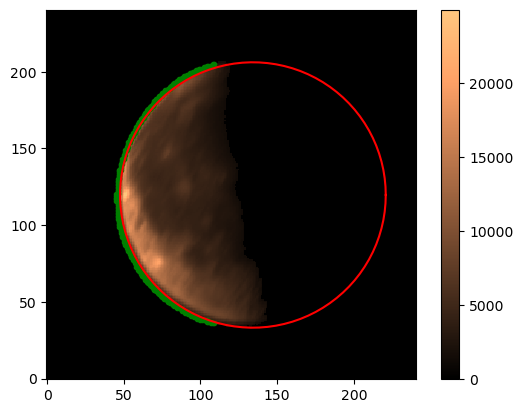

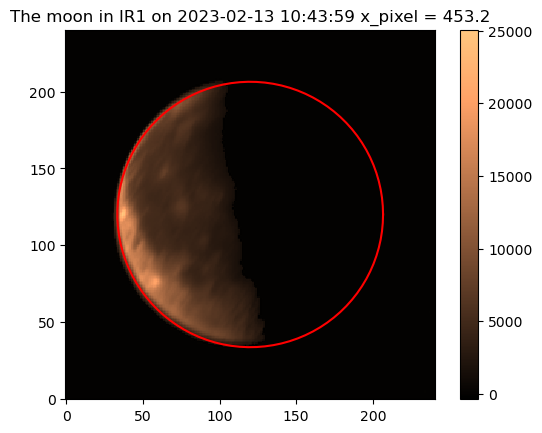

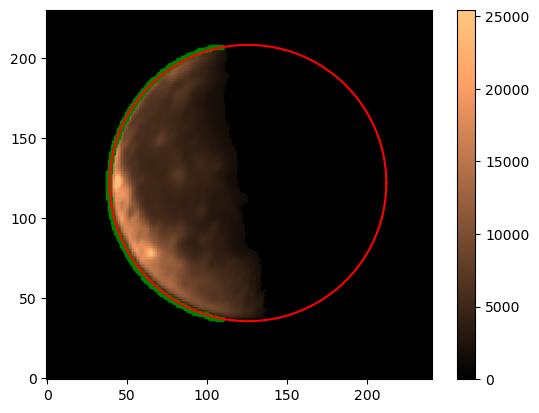

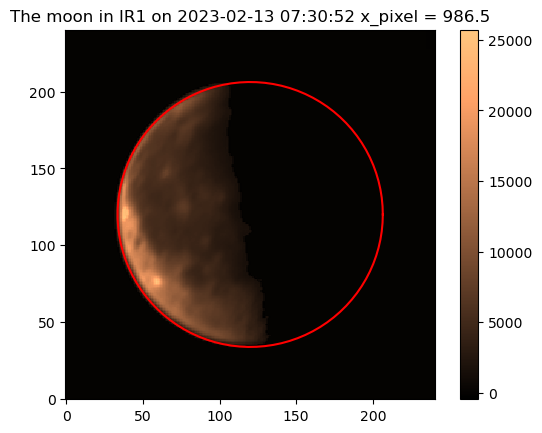

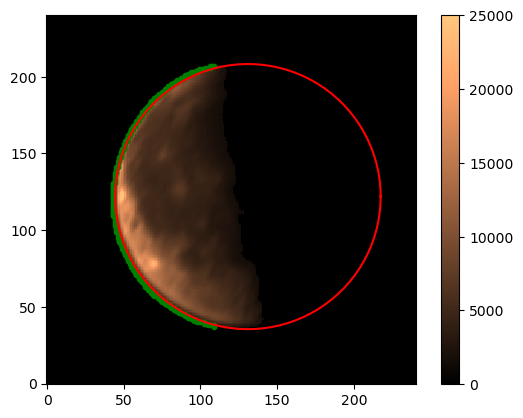

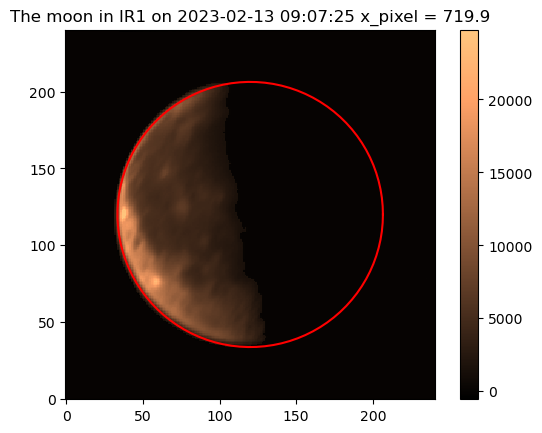

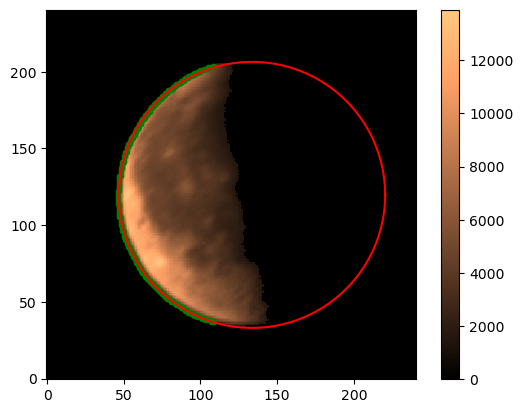

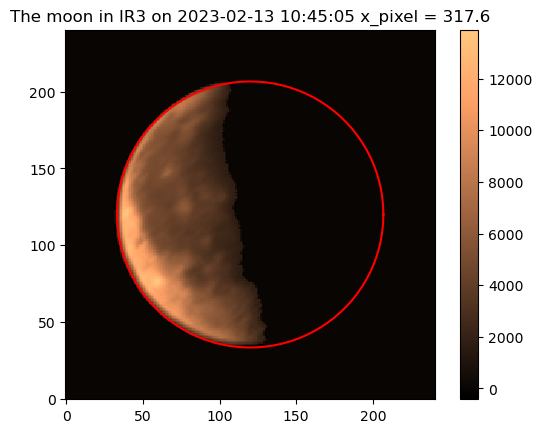

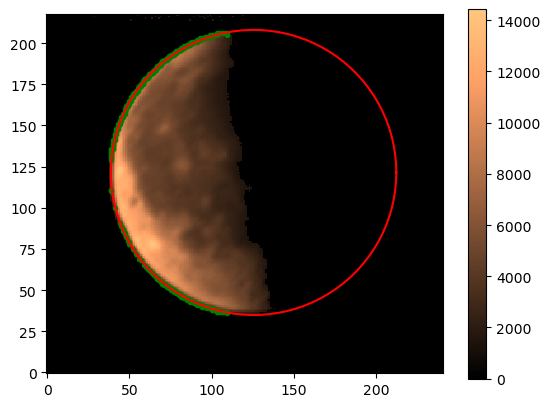

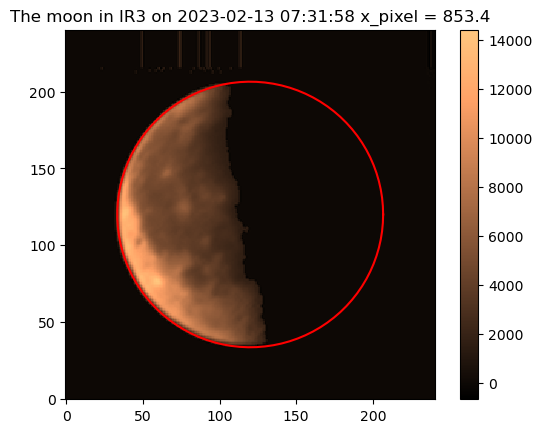

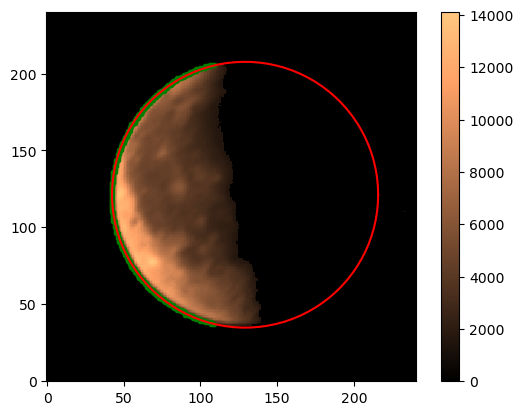

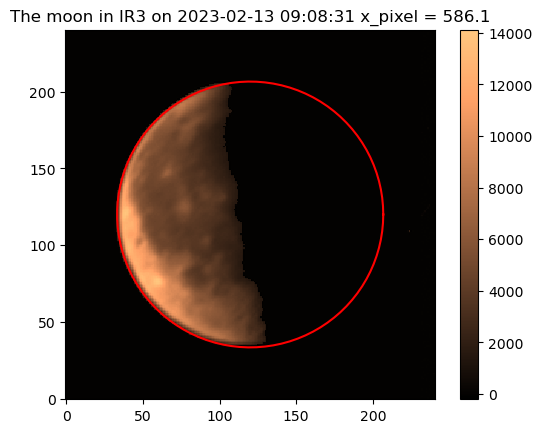

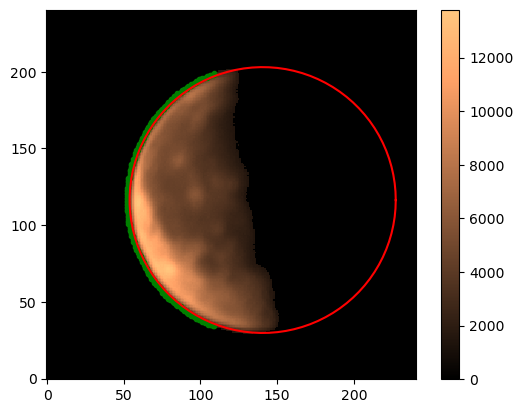

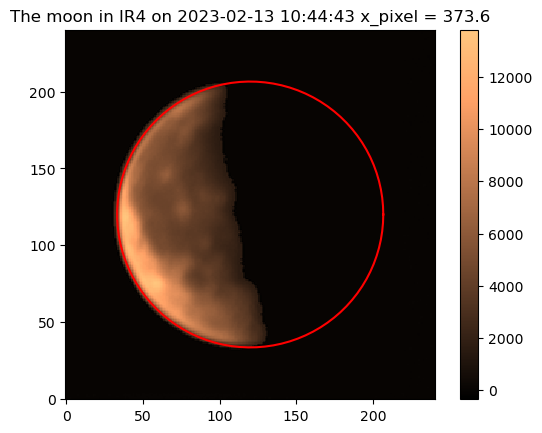

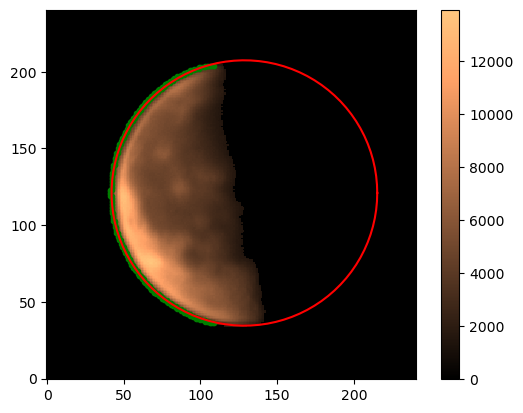

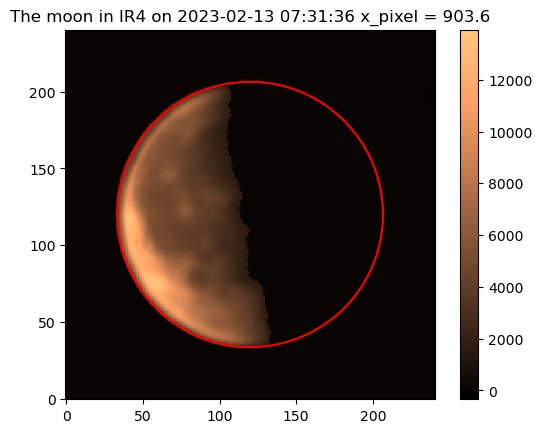

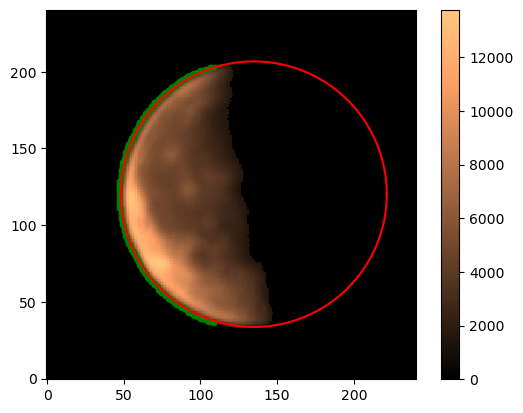

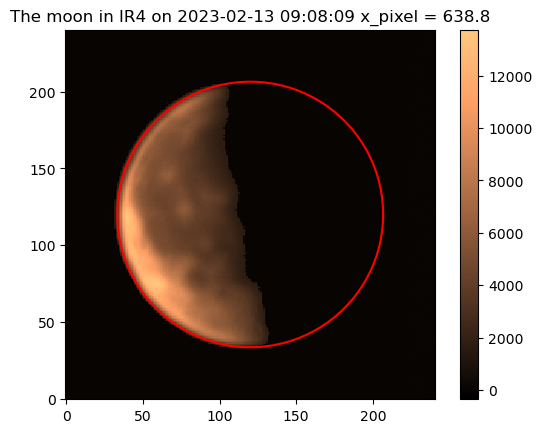

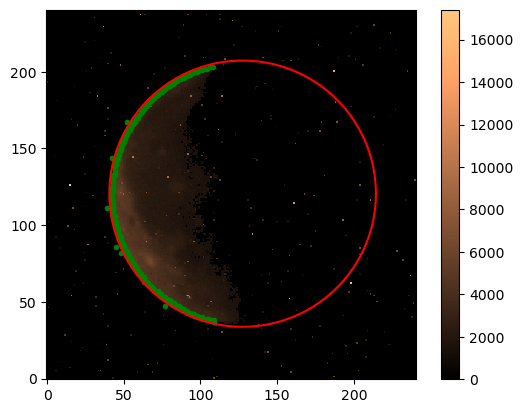

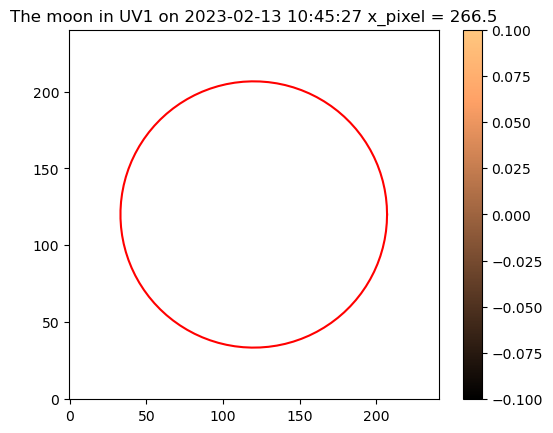

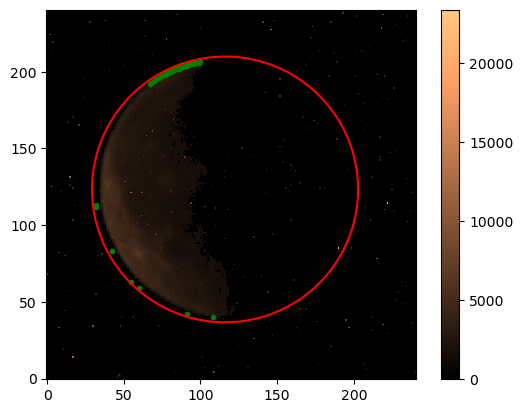

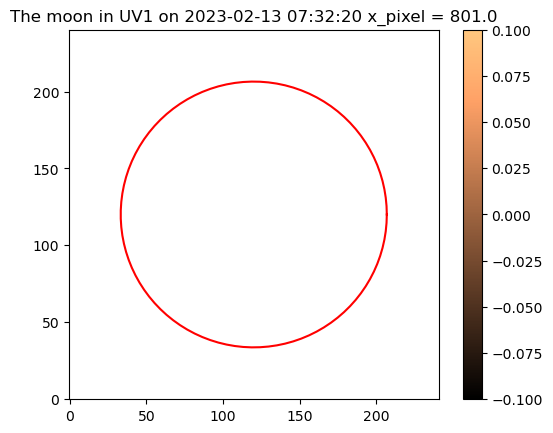

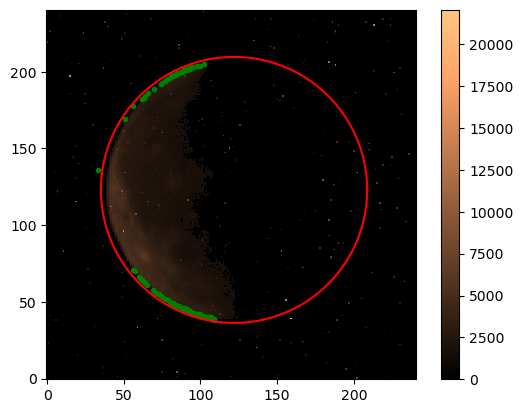

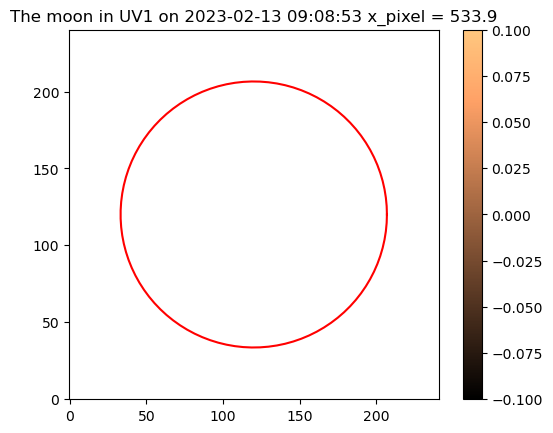

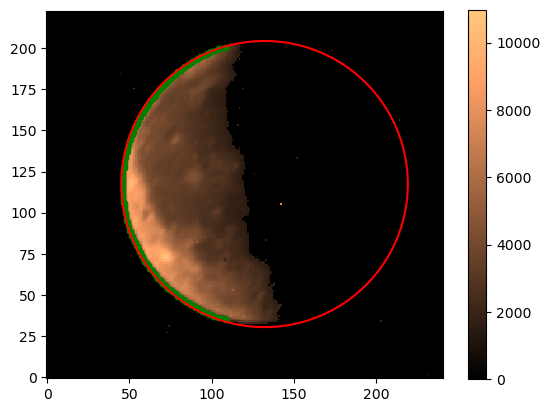

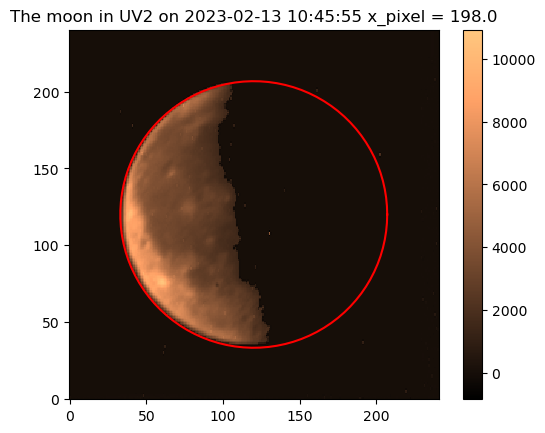

In [12]:
moons={}
channels=[ir1,ir3,ir4,uv1,uv2]
for ch in channels:
    label=ch['channel'][0]
    print(label)
    moons[label]=[]
    #print(moons)
    for i in range(3):
        res=resample_moon(ch.iloc[i])
        moons[label].append(res)

In [12]:
moons['IR1'][0]

(array([[ 5.13039752e+00,  3.41016620e+00,  2.05960575e+00, ...,
          1.16164020e+00,  9.74306285e+00,  1.16697578e+01],
        [-8.80237053e-01, -5.85092020e-01, -3.53372481e-01, ...,
          7.08107666e+00,  1.49045113e+01,  6.01454781e+00],
        [ 1.51024802e-01,  1.00385920e-01,  6.06291325e-02, ...,
          1.42567768e+01,  1.09807762e+01,  7.25447473e+00],
        ...,
        [-1.70309684e-02,  2.89583421e-02, -3.89943726e-02, ...,
          5.65851147e+00,  4.96469238e+00, -3.44574240e+00],
        [ 9.92637581e-02, -1.68781586e-01,  2.27275859e-01, ...,
          6.27069773e+00,  1.87625875e+01,  7.13715276e+00],
        [-5.78551580e-01,  9.83731177e-01, -1.32466078e+00, ...,
          1.04982908e+01,  1.93094216e+01,  7.00158551e+00]]),
 453.17576059483736,
 276.66770052428745)

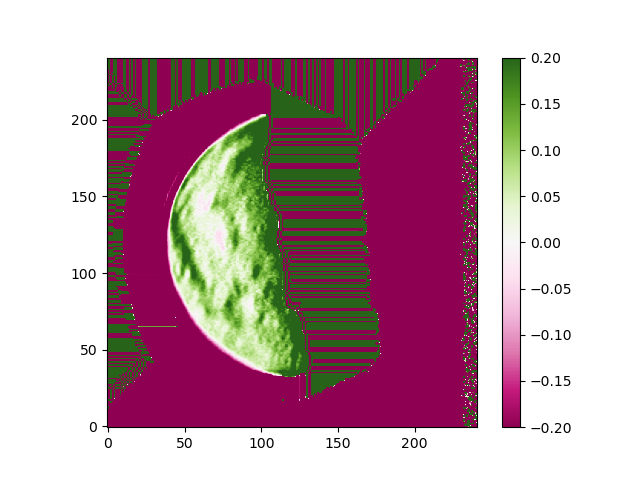

In [21]:
plt.figure()
plt.imshow((moons['IR4'][1][0]-moons['IR4'][0][0])/moons['IR4'][0][0],origin='lower',cmap="PiYG")#,norm=colors.CenteredNorm())
plt.clim([0-0.2, 0+0.2])
#plt.clim([-200,200])
plt.colorbar()

In [14]:
moons['IR3'][0][0].sum()

56601879.399702705

In [15]:
moons['IR3'][2][0].sum()

57691335.49624484

Text(0, 0.5, 'sum of intensity')

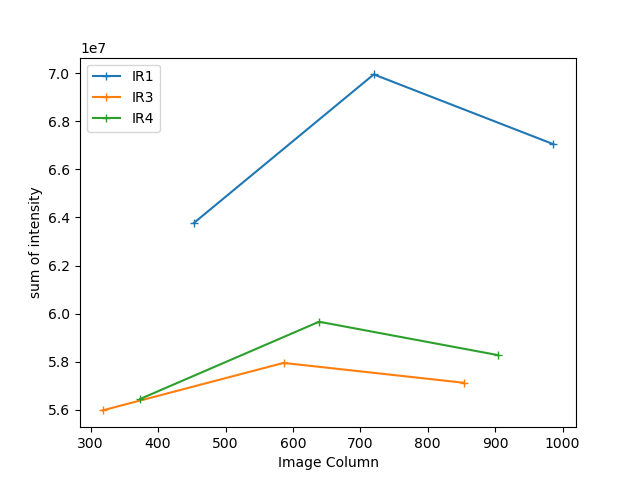

In [16]:
box=120
radius=86.61805475083472
xs,ys=np.meshgrid(np.arange(2*box+1)-box,np.arange(2*box+1)-box,sparse=True)
filter=(xs**2+ys**2)<radius**2
plt.figure()
names=['IR1','IR3','IR4']
for ch in names:
    xval= [moons[ch][i][1] for i in (0,2,1)]
    sums= [moons[ch][i][0][filter].sum() for i in range(3)]
    plt.plot(xval,sums,'-+')
plt.legend(names)
plt.xlabel('Image Column')
plt.ylabel('sum of intensity')

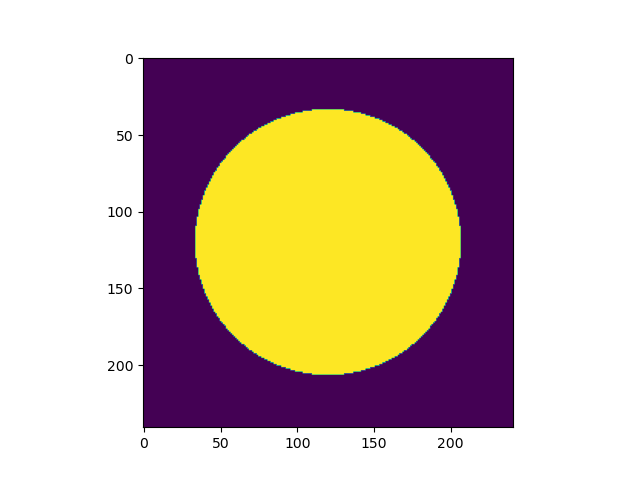

In [14]:
plt.figure()
plt.imshow(filter)

In [19]:
dfl1a = read_MATS_data(starttime, endtime,filter=None,level='1a',version='0.5')

In [20]:
print('Number of images = ',dfl1a.shape[0])
clim=999
plt.close('all')
ccdnames=('IR1','IR4','IR3','IR2','UV1','UV2','NADIR')
flip=(True,False,True,False,True,True,False)
ir1l1a=dfl1a[dfl1a.CCDSEL==1]
ir2l1a=dfl1a[dfl1a.CCDSEL==4]
ir3l1a=dfl1a[(dfl1a.CCDSEL==3)]
ir4l1a=dfl1a[(dfl1a.CCDSEL==2)]
uv1l1a=dfl1a[(dfl1a.CCDSEL==5)]
uv2l1a=dfl1a[(dfl1a.CCDSEL==6)]
for ch in [ir1l1a,ir2l1a,ir3l1a,ir4l1a,uv1l1a,uv2l1a]:
    print (ccdnames[ch.CCDSEL.iloc[0]-1],  ch.shape[0])
ir1l1a.shape

Number of images =  18
IR1 3
IR2 3
IR3 3
IR4 3
UV1 3
UV2 3


(3, 79)

IR1l1a
Radius =  86.3
Radius =  86.3
Radius =  86.3
IR3l1a
Radius =  86.3
Radius =  86.3
Radius =  86.3
IR4l1a
Radius =  86.3
Radius =  86.3
Radius =  86.3
UV1l1a
Radius =  86.3
Radius =  86.3
Radius =  86.3
UV2l1a
Radius =  86.3


IndexError: list index out of range

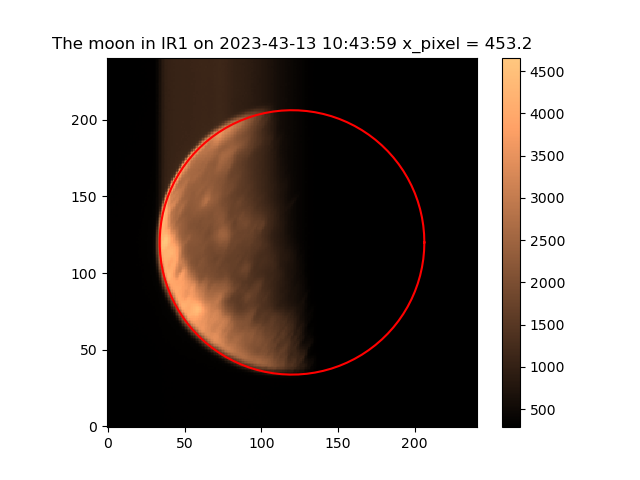

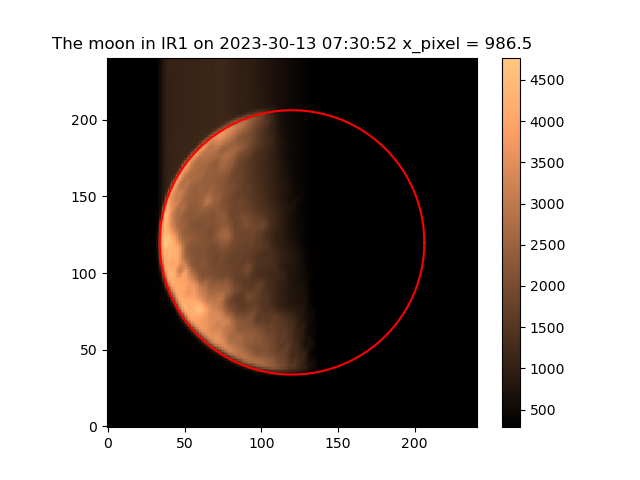

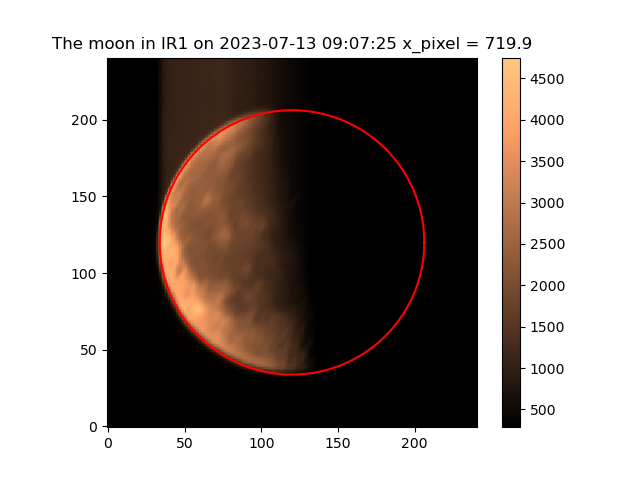

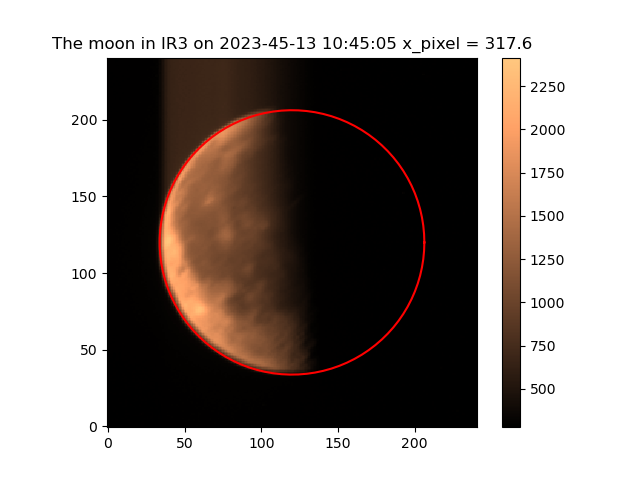

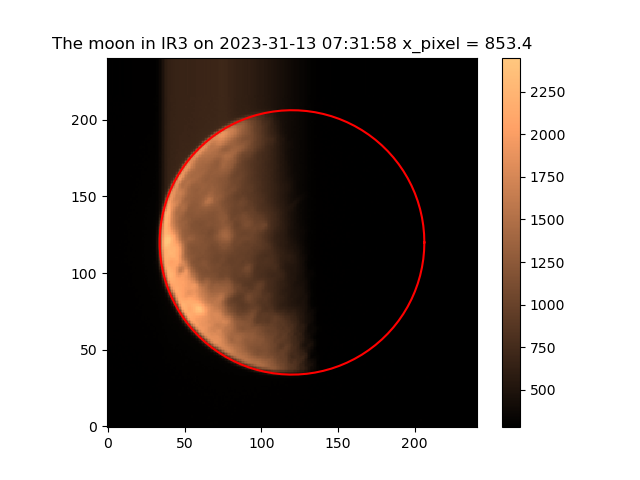

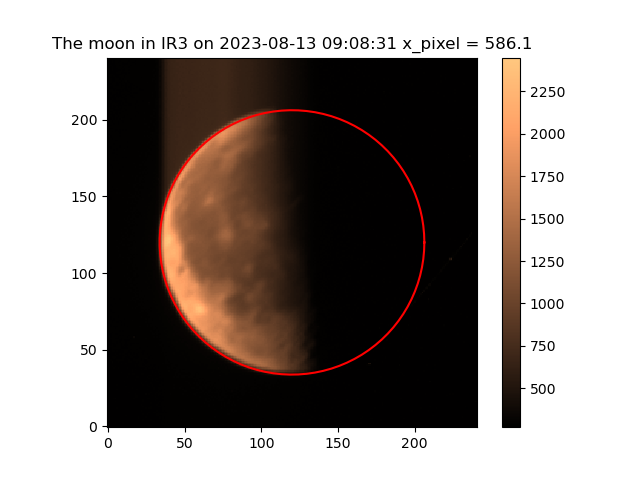

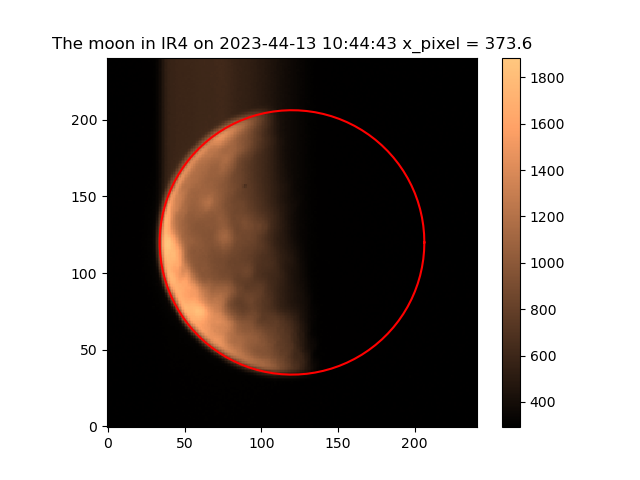

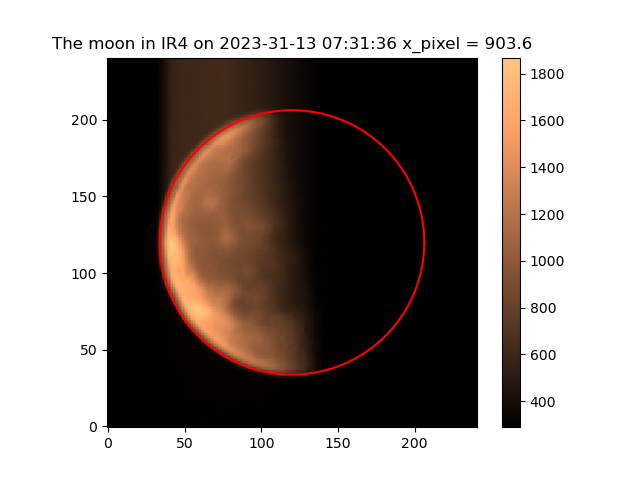

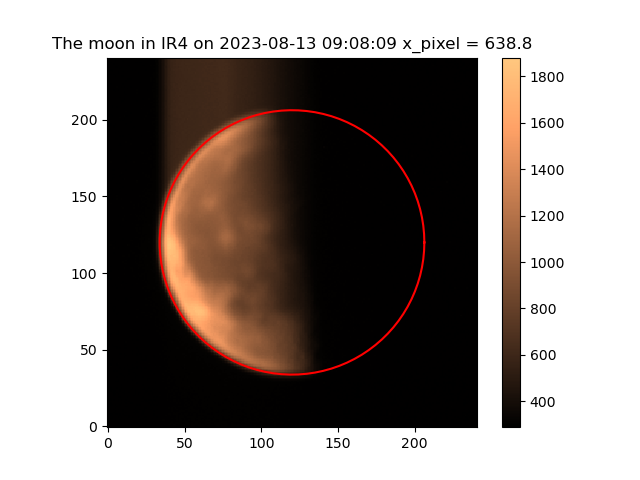

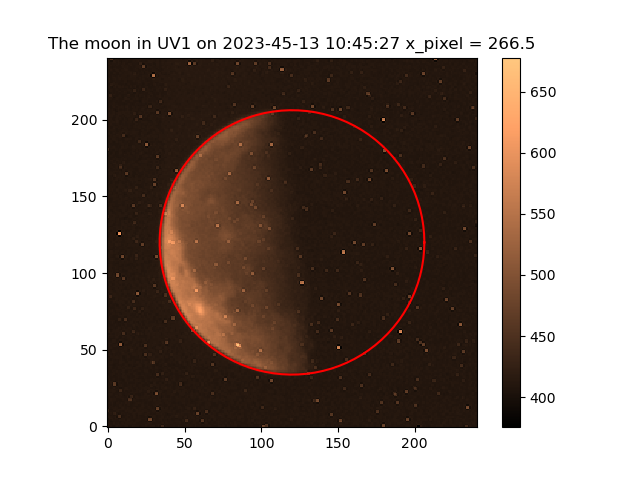

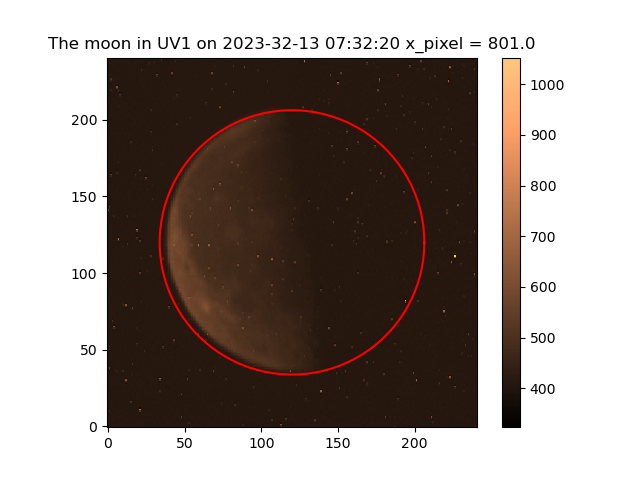

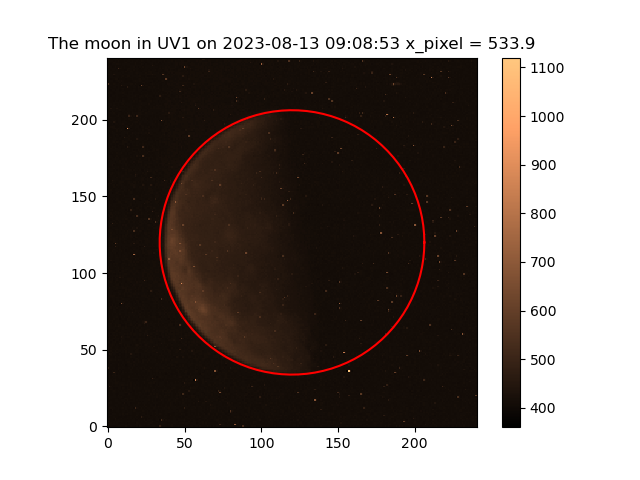

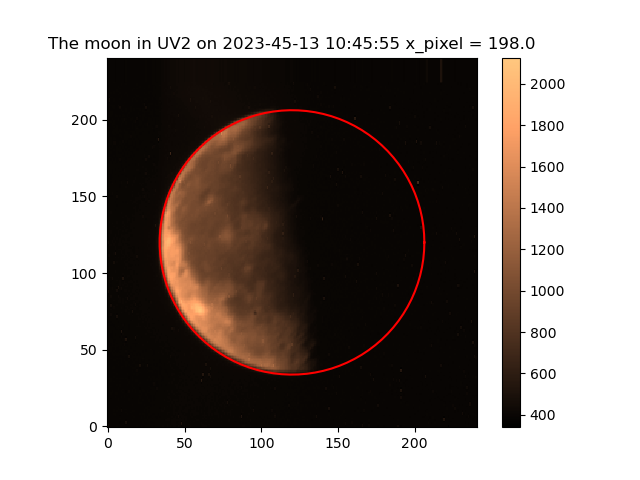

In [21]:

channels=[ir1l1a,ir3l1a,ir4l1a,uv1l1a,uv2l1a]
for ch in channels:
    oldlabel=ch['channel'][0]
    label=ch['channel'][0]+'l1a'
    print(label)
    moons[label]=[]
    #print(moons)
    for i in range(3):
        res=resample_moonl1a(ch.iloc[i],moons[oldlabel][i][1],moons[oldlabel][i][2])
        moons[label].append(res)

Text(0, 0.5, 'sum of intensity')

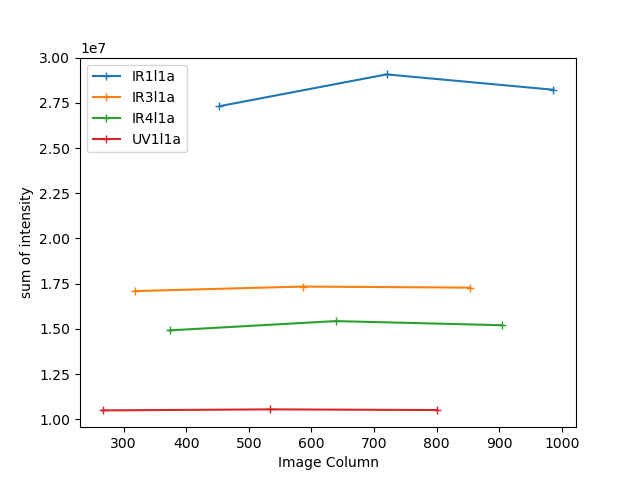

In [22]:
box=120
radius=86.61805475083472
xs,ys=np.meshgrid(np.arange(2*box+1)-box,np.arange(2*box+1)-box,sparse=True)
filter=(xs**2+ys**2)<radius**2
plt.figure()
names=['IR1l1a','IR3l1a','IR4l1a','UV1l1a']
for ch in names:
    xval= [moons[ch][i][1] for i in (0,2,1)]
    sums= [moons[ch][i][0][filter].sum() for i in range(3)]
    plt.plot(xval,sums,'-+')
plt.legend(names)
plt.xlabel('Image Column')
plt.ylabel('sum of intensity')

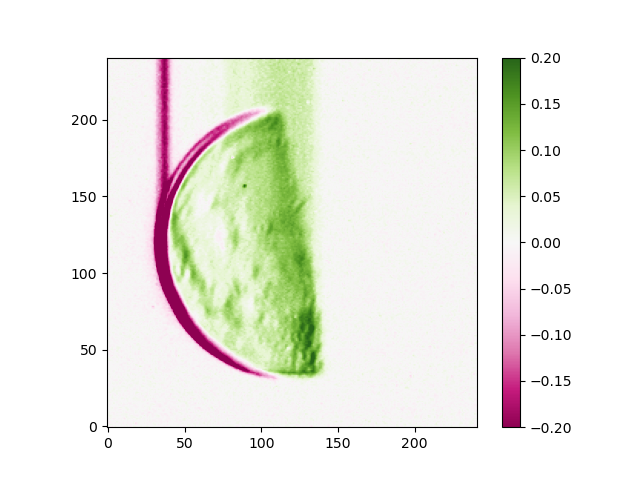

In [ ]:
plt.figure()
plt.imshow((moons['IR4l1a'][1][0]-moons['IR4l1a'][0][0])/moons['IR4l1a'][1][0],origin='lower',cmap="PiYG")#,norm=colors.CenteredNorm())
plt.clim([0-0.2, 0+0.2])
#plt.clim([-200,200])
plt.colorbar()

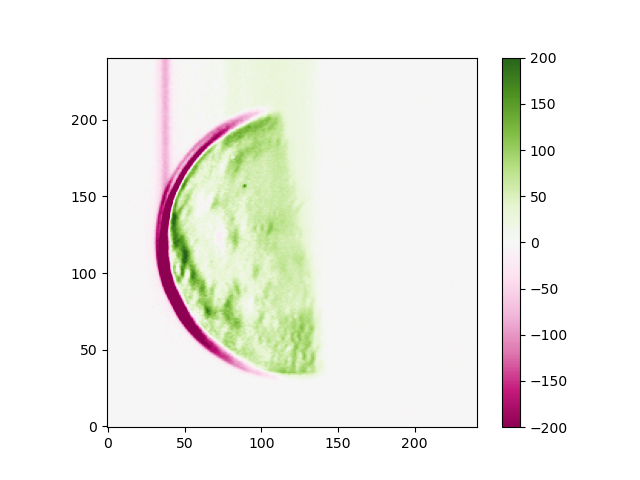

In [18]:
plt.figure()
plt.imshow((moons['IR4l1a'][1][0]-moons['IR4l1a'][0][0]),origin='lower',cmap="PiYG")#,norm=colors.CenteredNorm())
#plt.clim([0-0.2, 0+0.2])
plt.clim([-200,200])
plt.colorbar()

In [32]:
moons['IR1'][2]

(array([[ 2.27608950e-02, -7.26777245e-03,  4.90435337e-02, ...,
         -1.84961320e+00,  9.18481261e+00,  1.27865595e+01],
        [-3.90515325e-03,  1.24695280e-03, -8.41454012e-03, ...,
         -7.89888102e+00,  1.67911394e-01,  8.89713210e+00],
        [ 6.70016740e-04, -2.13942996e-04,  1.44370679e-03, ...,
          7.48449099e+00,  8.69920981e+00,  9.16771920e+00],
        ...,
        [-7.65273884e-01, -1.52846377e+00, -5.75343554e-02, ...,
          8.32300626e+00,  1.54410089e+00,  1.41172360e+01],
        [ 1.01573060e+01,  2.12504588e+01,  1.65808500e+00, ...,
          1.92668104e+00,  5.21349717e+00, -1.57690046e+01],
        [-3.40252352e+00,  3.69374578e+00,  9.26371724e+00, ...,
          3.81403890e+00,  6.82183932e+00, -3.53112227e-01]]),
 719.939762514759,
 329.875259227557)

2048